# Bike Sharing Experimentation and Causal Analysis

Kara Jia  3031907464

In [1]:
import pandas as pd 
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from scipy import stats
from tqdm import tqdm_notebook as tqdm
 

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.display import Markdown, display

In [5]:
chicago = pd.read_csv("/Users/kyjurou/Documents/Courses/bikeshare_proj/bikeshare/chicago.csv")
ny = pd.read_csv("/Users/kyjurou/Documents/Courses/bikeshare_proj/bikeshare/ny.csv")  
day = pd.read_csv("/Users/kyjurou/Documents/Courses/bikeshare_proj/bikeshare/day.csv")
dc = pd.read_csv("/Users/kyjurou/Documents/Courses/bikeshare_proj/bikeshare/dc.csv")

In [6]:
chicago.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,926,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0
1,9080521,3/31/2016 22:59,3/31/2016 23:02,3439,198,259,California Ave & Francis Pl,276,California Ave & North Ave,Subscriber,Male,1974.0
2,9080479,3/31/2016 22:24,3/31/2016 22:26,4337,124,344,Ravenswood Ave & Lawrence Ave,242,Damen Ave & Leland Ave,Subscriber,Female,1992.0
3,9080475,3/31/2016 22:22,3/31/2016 22:41,3760,1181,318,Southport Ave & Irving Park Rd,458,Broadway & Thorndale Ave,Subscriber,Female,1979.0
4,9080443,3/31/2016 22:08,3/31/2016 22:19,1270,656,345,Lake Park Ave & 56th St,426,Ellis Ave & 60th St,Subscriber,Female,1997.0


## 1. Exploratory Data Analysis

### 1.1 Demographic Information

#### 1.1.1 Distribution of gender for riders

1. For chicago.csv

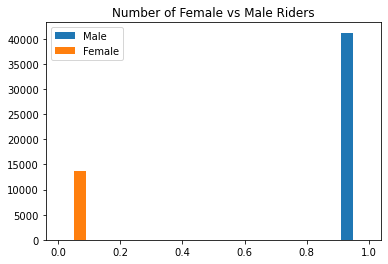

In [5]:
chicago_male = chicago[chicago.gender == 'Male'].gender
chicago_female = chicago[chicago.gender == 'Female'].gender
chicago_gender = [np.ones(len(chicago_male)), np.zeros(len(chicago_female))]
plt.hist(chicago_gender, label = ['Male','Female'])
plt.legend()
plt.title('Number of Female vs Male Riders');

2. For ny.csv

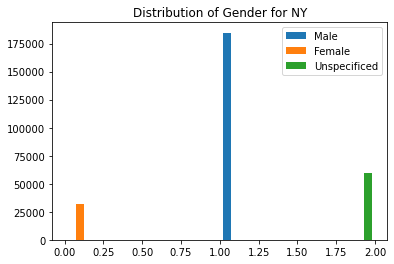

In [6]:
ny_male = ny[ny.gender == 1].gender
ny_female = ny[ny.gender == 0].gender
ny_unknown = ny[ny.gender == 2].gender
ny_gender = [np.ones(len(ny_male)), np.zeros(len(ny_female)), [2]*len(ny_unknown)]
plt.hist(ny_gender, label = ['Male','Female','Unspecificed'])
plt.title('Distribution of Gender for NY')
plt.legend();

3. Washington DC dataset has no gender attribute.

**Based on research online, females make up a small percentage of all bike share users. So it makes sense that 0 maps to Female, 1 maps to Male, and 2 maps to unspecified. After looking at the NaNs in Chicago, it turns out that the number of NaNs is also consistently higher than females, which is a pattern we see in NY.**

#### 1.1.2. Distribution of Birth Years in Chicago and NY

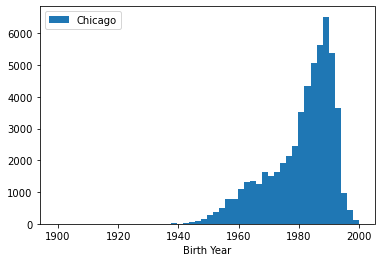

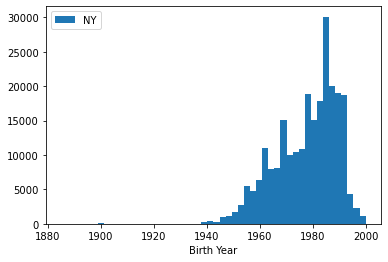

In [7]:
plt.hist(chicago['birthyear'].dropna(), bins = 50, label = 'Chicago')
plt.legend()
plt.xlabel('Birth Year')
plt.show()
plt.hist(ny['birth year'].dropna(), bins = 50, label = 'NY')
plt.legend()
plt.xlabel('Birth Year')
plt.show()

**It seems like there are people who are over 100 years old who are renting bikes. I don't think this is realistic (may have been a typo. They probably meant 1980 instead of 1880) so I think it would make sense to drop these data points.**

### 1.2 Rental Times

#### 1.2.1 Visualize the three distribution of trip duration in minutes across all three cities

In [8]:
chicago['tripduration'] = chicago.tripduration/60
ny['tripduration'] = ny.tripduration/60
dc['Duration (min)'] = dc['Duration (ms)']/60000

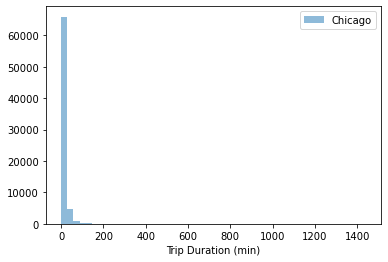

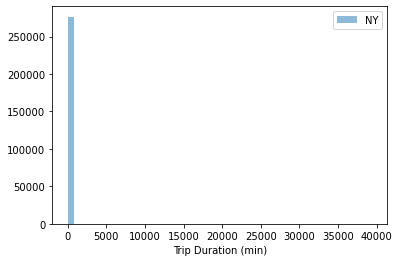

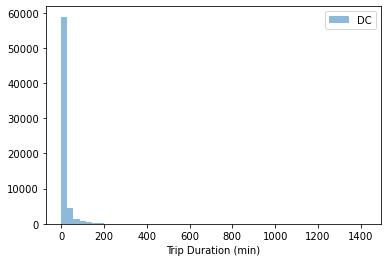

In [9]:
plt.hist(chicago.tripduration, bins = 50, alpha = 0.5, label = 'Chicago')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show();
plt.hist(ny.tripduration, bins = 50, alpha = 0.5, label = 'NY')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show();
plt.hist(dc['Duration (min)'], bins = 50, alpha = 0.5, label = 'DC')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show();

**The plots above are not useful. I will drop the extreme values since they are outliers and probably due to the fact that someone either stole the bike or didn't dock it correctly**

In [10]:
chicago = chicago[chicago.tripduration <= 100]
ny = ny[ny.tripduration <= 100]
dc = dc[dc['Duration (min)'] < 100]

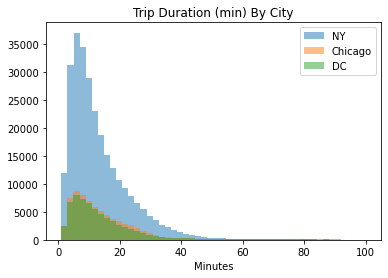

In [11]:
plt.hist(ny[ny.tripduration < 100].tripduration, bins = 50, alpha = 0.5, label = 'NY')
plt.hist(chicago[chicago.tripduration < 100].tripduration, bins = 50, alpha = 0.5, label = 'Chicago')
plt.hist((dc[dc['Duration (min)'] < 100]['Duration (min)']), bins = 50, alpha = 0.5, label = 'DC')
plt.legend()
plt.title('Trip Duration (min) By City')
plt.xlabel('Minutes');

#### 1.2.2 Visualize start time trips by city split by hour 

In [12]:
ny['starttime'] = pd.to_datetime(ny.starttime)
chicago['starttime'] = pd.to_datetime(chicago.starttime)
dc['Start date'] = pd.to_datetime(dc['Start date'])

ny['stoptime'] = pd.to_datetime(ny.stoptime)
chicago['stoptime'] = pd.to_datetime(chicago.stoptime)
dc['End date'] = pd.to_datetime(dc['End date'])

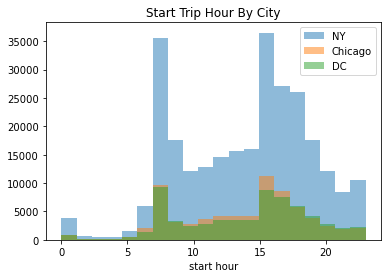

In [13]:
ny_start_hour = ny.starttime.dt.hour
chicago_start_hour = chicago.starttime.dt.hour
dc_start_hour = dc['Start date'].dt.hour

plt.hist(ny_start_hour, bins = 20, alpha = 0.5, label = 'NY')
plt.hist(chicago_start_hour, bins = 20, alpha = 0.5, label = 'Chicago')
plt.hist(dc_start_hour, bins = 20, alpha = 0.5, label = 'DC')
plt.legend()
plt.title('Start Trip Hour By City')
plt.xlabel('start hour');

**Interpreting trip activity by hour is intuitive. I would assume people would bike during the day time and it seems like the most activity occurs between 8 AM and 6PM. There are also two spikes around 8AM and 5PM, which seem to indicate when people go to and get off from work.**

### 1.3 Further exploration

#### 1.3.1 Visualize popular routes

**Attribute One: Popular Routes (Start to End Stations)**


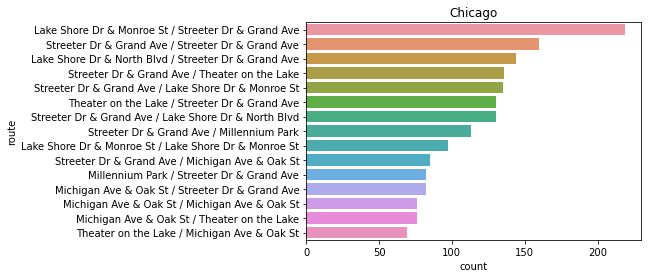

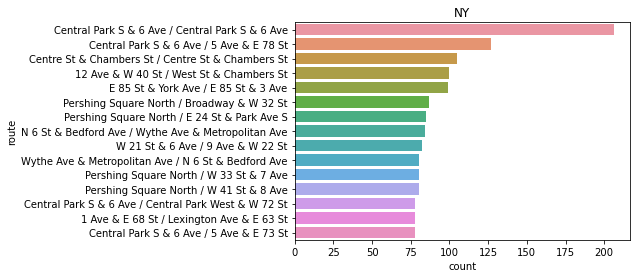

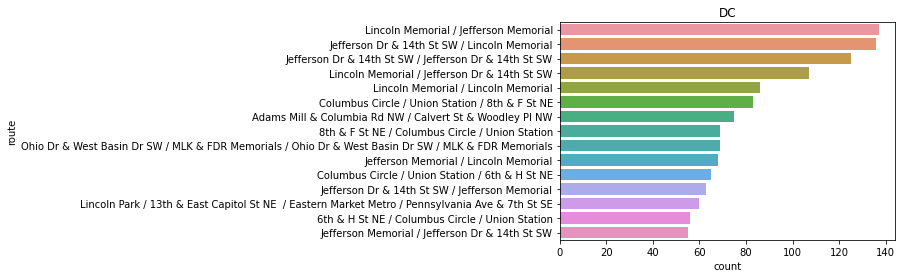

In [18]:
ny['route'] = ny['start station name'] + ' / ' + ny['end station name']
chicago['route'] = chicago.from_station_name + ' / ' + chicago.to_station_name
dc['route'] = dc['Start station'] + ' / ' + dc['End station']

ny_popular_routes = ny.groupby('route').count().sort_values('tripduration',ascending=False).head(15).reset_index().rename({'tripduration':'count'},axis=1)
chicago_popular_routes = chicago.groupby('route').count().sort_values('trip_id',ascending=False).head(15).reset_index().rename({'trip_id':'count'},axis=1)
dc_popular_routes =  dc.groupby('route').count().sort_values('Start date',ascending=False).head(15).reset_index().rename({'Start date':'count'},axis=1)

print("**Attribute One: Popular Routes (Start to End Stations)**")
sns.barplot(x="count", y='route', data=chicago_popular_routes).set_title('Chicago')
plt.show()
sns.barplot(x="count", y='route', data=ny_popular_routes).set_title('NY')
plt.show()
sns.barplot(x="count",y='route',data=dc_popular_routes).set_title('DC')
plt.show()

#### 1.3.2 Visualize number of roundtrips


In [19]:
chicago['roundtrip'] = (chicago.from_station_id == chicago.to_station_id).apply(lambda x: int(x))
chicago_route_counts = chicago.groupby('route').count()[['trip_id']].rename({'trip_id':'count'},axis=1).reset_index()
chicago_tripduration = chicago.groupby('route').mean().sort_values('tripduration',ascending=False).round()[['tripduration','roundtrip']].reset_index()
chicago_route_durations = chicago_route_counts.merge(chicago_tripduration, on = 'route')
chicago_route_durations = chicago_route_durations[chicago_route_durations.tripduration <= 4000]

dc['roundtrip'] = (dc['Start station'] == dc['End station']).apply(lambda x: int(x))
dc_route_counts = dc.groupby('route').count()[['Start date']].rename({'Member Type':'count'},axis=1).reset_index()
dc_tripduration = dc.groupby('route').mean().sort_values('Duration (ms)',ascending=False).round()[['Duration (ms)','roundtrip']].reset_index()
dc_route_durations = dc_route_counts.merge(dc_tripduration, on = 'route')
dc_route_durations = dc_route_durations[dc_route_durations['Duration (ms)'] <= 40000]

ny['roundtrip'] = (ny['start station name'] == ny['end station name']).apply(lambda x: int(x))
ny_route_counts = ny.groupby('route').count()[['bikeid']].rename({'trip_id':'count'},axis=1).reset_index()
ny_tripduration = ny.groupby('route').mean().sort_values('tripduration',ascending=False).round()[['tripduration','roundtrip']].reset_index()
ny_route_durations = ny_route_counts.merge(ny_tripduration, on = 'route')
ny_route_durations = ny_route_durations[ny_route_durations.tripduration <= 4000]

roundtrips = pd.DataFrame({'City':list(['Chicago']*len(chicago[chicago.roundtrip==1])+['NY']*len(ny[ny.roundtrip==1])+['DC']*len(dc[dc.roundtrip==1])),
              'roundtrip':pd.concat([chicago[chicago.roundtrip==1].roundtrip,ny[ny.roundtrip==1].roundtrip,dc[dc.roundtrip==1].roundtrip])})
onewaytrips = pd.DataFrame({'City':list(['Chicago']*len(chicago[chicago.roundtrip==0])+['NY']*len(ny[ny.roundtrip==0])+['DC']*len(dc[dc.roundtrip==0])),
              'roundtrip':pd.concat([chicago[chicago.roundtrip==0].roundtrip,ny[ny.roundtrip==0].roundtrip,dc[dc.roundtrip==0].roundtrip])})

**Attribute Two: Number of Trips (Round/One-Way) Per City**


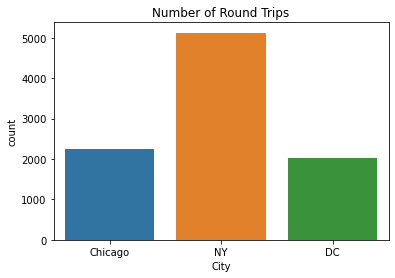

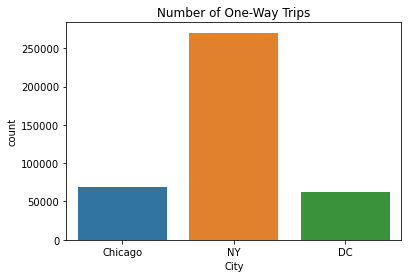

In [21]:
print("**Attribute Two: Number of Trips (Round/One-Way) Per City**")

sns.countplot(roundtrips.City).set_title('Number of Round Trips')
plt.show()
sns.countplot(onewaytrips.City).set_title('Number of One-Way Trips')
plt.show()

#### 1.3.3. Visualize trip duration based on age

**Attribute Three: Comparing tripduration based on birthyear (DC doesn't have this feature)**


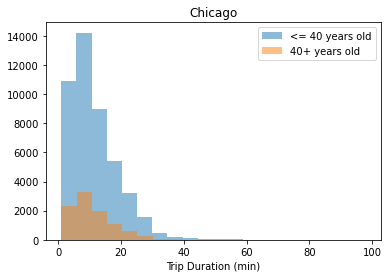

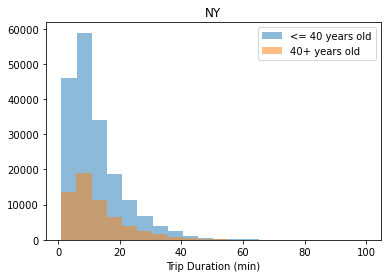

In [22]:
print("**Attribute Three: Comparing tripduration based on birthyear (DC doesn't have this feature)**")
plt.hist(chicago[chicago.birthyear>=1970].tripduration, bins = 20,alpha = 0.5, label = '<= 40 years old')
plt.hist(chicago[chicago.birthyear<1970].tripduration, bins = 20,alpha = 0.5, label = '40+ years old')
plt.title('Chicago')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show()

plt.hist(ny[ny['birth year']>=1970].tripduration, bins = 20,alpha = 0.5, label = '<= 40 years old')
plt.hist(ny[ny['birth year']<1970].tripduration, bins = 20,alpha = 0.5, label = '40+ years old')
plt.title('NY')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show()


#### 1.3.4 Insights

Visualization 1.3.1. shows which routes were most popular amongst users in each city. Many of them are located near parks, areas of water, or memorials (based on name of station). In 1.3.2, I then wanted to see what kind of trips people were taking. It seems that most of them are one way trips, but there are a few roundtrips. The ratio of one-way and roundtrips between cities is roughly the same. Finally, 1.3.3. explores  whether age would affect trip duration, and it turns out it doesn't make a huge difference. I tested different partitions (30, 40, 50) and they all consistently averaged around the same trip times. 

#### 1.3.3. Exploring the trip duration of popular routes
Attempting to get a plausible explanation for the shape of the distribution in each bike share dataset.

In [23]:
c_pop_routes = chicago[chicago.route.isin(chicago_popular_routes['route'])]
n_pop_routes = ny[ny.route.isin(ny_popular_routes.route)]
d_pop_routes = dc[dc.route.isin(dc_popular_routes.route)]

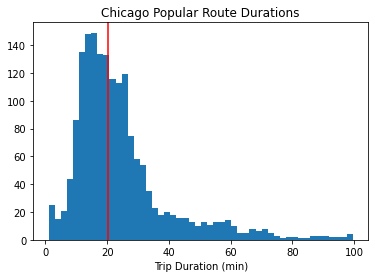

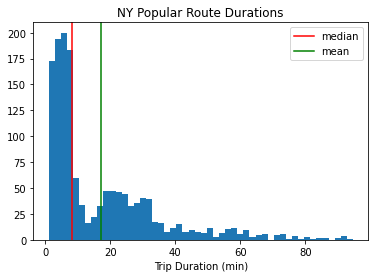

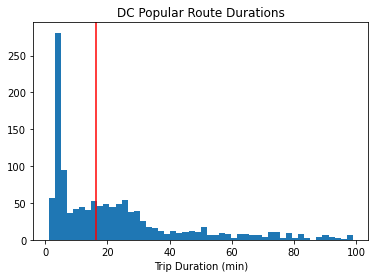

In [24]:
plt.hist(c_pop_routes.tripduration, bins = 50)
plt.xlabel('Trip Duration (min)')
plt.title('Chicago Popular Route Durations')
plt.axvline(np.median(c_pop_routes.tripduration),color='red')
plt.show()
plt.hist(n_pop_routes.tripduration, bins = 50)
plt.xlabel('Trip Duration (min)')
plt.title('NY Popular Route Durations')
plt.axvline(np.median(n_pop_routes.tripduration),color='red',label = 'median')
plt.axvline(np.mean(n_pop_routes.tripduration),color='green',label='mean')
plt.legend()
plt.show()
plt.hist(d_pop_routes['Duration (min)'], bins = 50)
plt.xlabel('Trip Duration (min)')
plt.title('DC Popular Route Durations')
plt.axvline(np.median(d_pop_routes['Duration (min)']),color='red')
plt.show();

In [26]:
print('**Descriptive Statistics for Chicago, NY, DC**')
print('Average Trip Duration:\t\t\t',round(chicago.tripduration.mean()), round(ny.tripduration.mean()), round(dc['Duration (min)'].mean()))
print('Average Trip Duration of Popular Routes:', round(c_pop_routes.tripduration.mean()),round(n_pop_routes.tripduration.mean()),round(dc['Duration (min)'].mean()))
print()
print('Median Trip Durations:\t\t\t',round(chicago.tripduration.median()), round(ny.tripduration.median()), round(dc['Duration (min)'].median()))
print('Median Trip Durations of Popular Routes:',round(c_pop_routes.tripduration.median()),round(n_pop_routes.tripduration.median()),round(dc['Duration (min)'].median()))

**Descriptive Statistics for Chicago, NY, DC**
Average Trip Duration:			 15 13 15
Average Trip Duration of Popular Routes: 24 17 15

Median Trip Durations:			 12 10 11
Median Trip Durations of Popular Routes: 20 8 11


**Usertype Trip Durations**


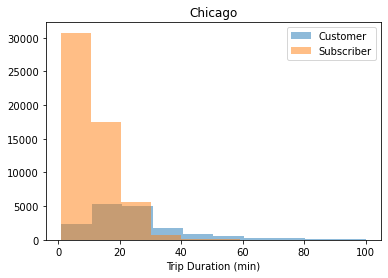

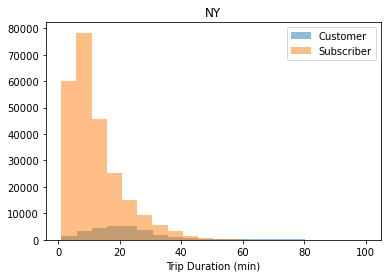

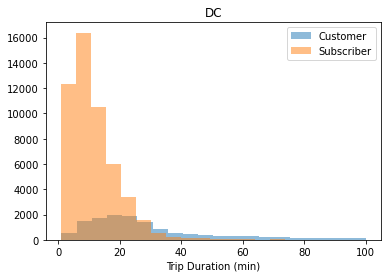

In [28]:
print("**Usertype Trip Durations**")
plt.hist(chicago[chicago.usertype=='Customer'].tripduration, alpha = 0.5, label = 'Customer')
plt.hist(chicago[chicago.usertype=='Subscriber'].tripduration, alpha = 0.5, label = 'Subscriber')
plt.title('Chicago')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show()
plt.hist(ny[ny.usertype=='Customer'].tripduration, bins = 20,alpha = 0.5, label = 'Customer')
plt.hist(ny[ny.usertype=='Subscriber'].tripduration, bins = 20,alpha = 0.5, label = 'Subscriber')
plt.title('NY')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show()
plt.hist(dc[dc['Member Type']=='Casual']['Duration (min)'], bins = 20, alpha = 0.5, label = 'Customer')
plt.hist(dc[dc['Member Type']=='Registered']['Duration (min)'], bins = 20, alpha = 0.5, label = 'Subscriber')
plt.title('DC')
plt.xlabel('Trip Duration (min)')
plt.legend()
plt.show()

In [32]:
print("**A comparison between all routes versus popular routes, given user type**")
print("**Chicago**")
display(chicago.groupby('usertype').count()[['route']],c_pop_routes.groupby('usertype').count()[['route']])
print("**NY**")
display(ny.groupby('usertype').count()[['route']],n_pop_routes.groupby('usertype').count()[['route']])
print("**DC**")
display(dc.groupby('Member Type').count()[['route']],d_pop_routes.groupby('Member Type').count()[['route']])

**A comparison between all routes versus popular routes, given user type**
**Chicago**


,route
usertype,
Customer,16644
Subscriber,54907


,route
usertype,
Customer,1434
Subscriber,300


**NY**


,route
usertype,
Customer,29350
Subscriber,245398


,route
usertype,
Customer,546
Subscriber,897


**DC**


,route
Member Type,
Casual,13365
Registered,51631


,route
Member Type,
Casual,759
Registered,495


#### 1.3.4. Insights and proposed hypothesis

 I noticed that popular routes are often taken by customers rather than subscribers. Initially this made sense to me because I felt that popular routes are scenic/leisure trips, hence they are more occasional, so those who take them tend to be one time customers opposed to subscribers who rely on bikes as their main form of transportation. However, after visualizing just user types (independent from route popularity) I found that customers tend to take longer trips in general. So, I'd like to test whether the difference in average trip time between customers and subscribers is significant. I would go about this by conducting a simple t test with an alpha = 0.05. 

## 2. Hypothesis Testing with Logistic Regression

The feature that indicates whether each bike ride corresponds to a casual (customer) or non-casual (subscriber) is particularly useful, because depending on the type of user the bike share company might want to give them different promotions and advertisement. In this part, I will design a test for whether the user is casual or not. I will also try to prevent too many false discoveries, i.e. falsely declaring a casual user as a non-casual one.

If the company were to remove the feature that indicts which riders are customers or subscribers due to a change in its privacy policy, designing a test like this one can help the company differentiate between customer or subscriber riders.

### 2.1 Training a logistic regression model

In [33]:
from sklearn.linear_model import LogisticRegression

I split the data into 60/20/20 train-validation-test set.

In [34]:
X = ['tripduration','starttime', 'stoptime']
y = 'usertype'

chicago1 = chicago[['tripduration','starttime', 'stoptime','usertype']]
chicago1['starttime'] = chicago1.starttime.dt.hour
chicago1['stoptime'] = chicago1.stoptime.dt.hour
chicago1['usertype'] = chicago1['usertype'].map({'Customer':0,'Subscriber':1})

train = chicago1.sample(frac = 0.6)
val = chicago1[~chicago1.index.isin(train.index)].sample(frac = 0.5)
test = chicago1[~(chicago1.index.isin(train.index.append(val.index)))]

train_y, val_y, test_y = train['usertype'], val['usertype'], test['usertype']
model = LogisticRegression()
model.fit(train.iloc[:,:3],train_y)

LogisticRegression()

### 2.2. Calculating p values

Our null hypothesis $H_0$ is the user is a casual (customer) rider.

To calculate the p-values, for each casual users in val set, sum the total predicted probabilities from test 
that are less than a user's predicted probability from val set and divide the sum by the total number of casual users in val set.

$$ 
P_j =\frac{1}{|S_{2,0}|}|\{i \in S_{2,0} : s_i^{(2)}>s_j^{(3)}\}| 
$$ where $|\cdot|$ is the cardinality of a set.



  0%|          | 0/14310 [00:00<?, ?it/s]

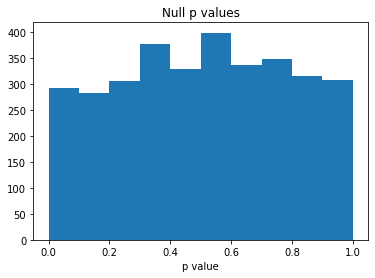

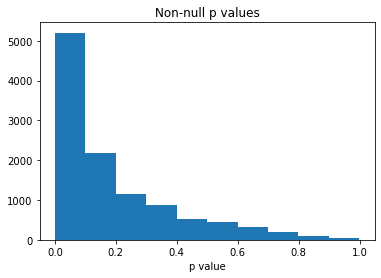

In [35]:
val_i = model.predict_proba(val.iloc[:,:3])[:,1] #train users
test_j = model.predict_proba(test.iloc[:,:3])[:,1] #predicted probabilities for 200 riders
val_0 = val[val.usertype == 0]
pvals = []
for j in tqdm(test_j):
    count = np.sum(val_i[np.where(val.usertype==0)] > j)  
    pvals.append(count/len(val_0))

test_copy = test.reset_index()
null_index = test_copy[test_copy['usertype']==0].index.values 
nonnull_index = test_copy[test_copy['usertype']==1].index.values 

pvals = np.array(pvals)
plt.hist(pvals[null_index])
plt.title('Null p values')
plt.xlabel('p value')
plt.show()

plt.hist(pvals[nonnull_index])
plt.title('Non-null p values')
plt.xlabel('p value')
plt.show()

For two-tailed test above, the p values under the null distribution are normally distributed, but have a long tail to the right for non null values.

### 2.3 Running BH algorithm & Finding FDR

To control for Type I errors, I will run the Benjamini-Hochberg algorithm to minimize the false discovery rate (FDR). FDR is the ratio of number of false positive FP results to the  number of total positive test results.

$$FDP = P(Result=0|Decision=1)= \frac{FP}{FP+TN}$$
$$FDR = E[FDP]$$

In [36]:
import statsmodels
from statsmodels.stats.multitest import multipletests as bh 

In [37]:
def report_results(predicted_discoveries, truth):
    # input: predicted discoveries: n-dimensional array of 0/1 values where 1 indicates a "discovery"
    #        truth: n-dimensional array of 0/1 values where 1 indicates a draw from the altertanative
    
    # populate the following dictionary with COUNTS:
    TP_count = np.sum((predicted_discoveries == 1) & (truth == 1))
    TN_count = np.sum((predicted_discoveries == 0) & (truth == 0))
    FP_count = np.sum((predicted_discoveries == 1) & (truth == 0))
    FN_count = np.sum((predicted_discoveries == 0) & (truth == 1))
    
    results_dictionary = {"TN_count": TN_count,
                          "TP_count": TP_count,
                          "FN_count": FN_count,
                          "FP_count": FP_count,
                         }
    
    # this function is defined for you below; this will make your life easier in a few steps.
    return results_dictionary

def fdp_sens(results_dictionary):
    # the results_dictionary object is defined via the output of report_results()
    
    total_predicted_discoveries = results_dictionary['TP_count'] + results_dictionary['FP_count']
    false_discovery_frac = results_dictionary['FP_count']/max(total_predicted_discoveries, 1)
    sensitivity = results_dictionary['TP_count']/(results_dictionary['TP_count']+results_dictionary['FN_count'])
    
    return [false_discovery_frac, sensitivity]

def print_false_discovery_fraction(results_dictionary):
    # the results_dictionary object is defined via the output of report_results()
    
    total_predicted_discoveries = results_dictionary.get("FP_count") + results_dictionary.get("TP_count")
    false_discovery_frac = results_dictionary.get('FP_count')/total_predicted_discoveries
    
    # leave this printing functions as they are; you will need them later
    print("total discoveries: {0}".format(total_predicted_discoveries))
    print("fraction of discoveries which were actually false: {0:.3f}".format(false_discovery_frac))
    return total_predicted_discoveries, false_discovery_frac

We set the alpha to .2 as a threshold for p-value to control Type I error.

In [38]:
bh_decisions = bh(pvals,alpha=.2, method='fdr_bh')
bh_decisions = np.array([int(x) for x in bh_decisions[0]])
bh_results = report_results(bh_decisions,test['usertype'].values)
print('false discovery proportion: {}, sensitivity: {}'.format(fdp_sens(bh_results)[0], fdp_sens(bh_results)[1]))

false discovery proportion: 0.043968432919954906, sensitivity: 0.3078878097485704


Here, we will use resampling to compute p-values. We will permute the labels and recalculate p-values. Sample 200 sets of test dataset to get 200 false discovery proportions to calculate false discovery rate FDR.

In [39]:
fdp_sensitivity = []
for _ in tqdm(range(200)):
    train = chicago1.sample(frac = 0.6)
    val = chicago1[~chicago1.index.isin(train.index)].sample(frac = 0.5)
    test = chicago1[~(chicago1.index.isin(train.index.append(val.index)))]

    train_y, val_y, test_y = train['usertype'], val['usertype'], test['usertype']
    model = LogisticRegression().fit(train.iloc[:,:3],train_y)
    
    val_i = model.predict_proba(val.iloc[:,:3])[:,1]
    test_j = model.predict_proba(test.iloc[:,:3])[:,1]
    val_0 = np.count_nonzero(val_y == 0)
    pvals = []
    val_y_copy = val_y.copy().reset_index()
    indices = val_y_copy[val_y_copy['usertype']==0].index.values 
    for j in test_j:
        count = np.sum(val_i[indices] > j)
        pvals.append(count/val_0)
        
    bh_decisions_ = bh(pvals,alpha=.2, method='fdr_bh')
    bh_decisions = np.array([int(x) for x in bh_decisions_[0]])
    results = fdp_sens(report_results(bh_decisions,test_y.values))
    fdp_sensitivity.append(results)

  0%|          | 0/200 [00:00<?, ?it/s]

In [40]:
avg_fdp = np.mean(np.array(fdp_sensitivity)[:,0])
avg_sensitivity = np.mean(np.array(fdp_sensitivity)[:,1])
print("**Initial FDP and Sensitivity**")
display(pd.DataFrame({'Metric':['FDP','Sensitivity'],'Value':[fdp_sens(bh_results)[0],fdp_sens(bh_results)[1]]}).round(2))
print("**Avg FDP and Sensitivity**")
display(pd.DataFrame({'Metric':['FDP','Sensitivity'],'Value':[avg_fdp, avg_sensitivity]}).round(2))

**Initial FDP and Sensitivity**


,Metric,Value
0,FDP,0.04
1,Sensitivity,0.31


**Avg FDP and Sensitivity**


,Metric,Value
0,FDP,0.05
1,Sensitivity,0.33


**The FDR (avg FDP) remains below alpha (.2).** This is because alpha controls the FDR which is the expected value of FDP. FDR of .05 means  5% of significant tests (null hypothesis rejected) will result in false positives.

Remember, using FDR to control Type I error instead of controlling FWER means the test has higher power at the cost of increased number of Type I errors. However for online experimentation settings, bonferroni can be used whereas benjamini-hochberg cannot.

### 2.4 Improving the Average Sensitivity

In [41]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

We want to control for sensitivity by making the histogram of non-null p-values more skewed to the left (i.e. make p-values smaller). We will do this by adding three new features (`gender`, `birthyear`, `roundtrip`) and perform log transformation on and standardizing `tripduration`.

In [42]:
X = ['tripduration','starttime', 'stoptime','gender','birthyear','roundtrip']
y = 'usertype'

chicago2 = chicago[['tripduration','starttime', 'stoptime','gender','birthyear','roundtrip','usertype']]
chicago2['starttime'] = chicago2.starttime.dt.hour
chicago2['stoptime'] = chicago2.stoptime.dt.hour
chicago2['usertype'] = chicago2['usertype'].map({'Customer':0,'Subscriber':1})
chicago2['birthyear'] = chicago2['birthyear'].fillna(chicago.birthyear.mean())
chicago2['gender'] = chicago2.gender.map({'Male':1,'Female':0}).fillna(2)
chicago2['tripduration'] = np.log(chicago2.tripduration)
chicago2['tripduration'] = scaler.fit_transform(chicago2[['tripduration']])

  0%|          | 0/14310 [00:00<?, ?it/s]

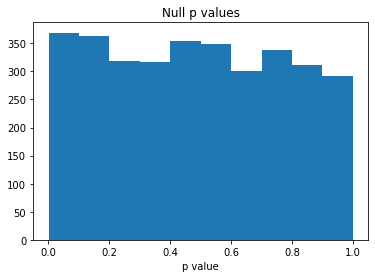

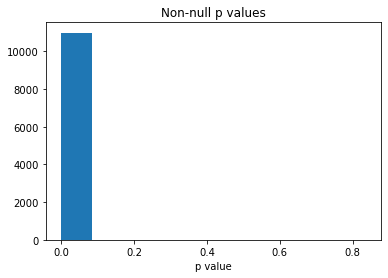

[0.052164166235557856, 0.9998180991359709]

In [43]:
train = chicago2.sample(frac = 0.6)
val = chicago2[~chicago2.index.isin(train.index)].sample(frac = 0.5)
test = chicago2[~(chicago2.index.isin(train.index.append(val.index)))]

train_y, val_y, test_y = train['usertype'], val['usertype'], test['usertype']
columns = list(val.columns)
columns.remove('usertype')
model = LogisticRegression()
model.fit(train[columns],train_y)


val_i = model.predict_proba(val[columns])[:,1]
test_j = model.predict_proba(test[columns])[:,1]
val_0 = val[val.usertype == 0]
indices = np.where(val.usertype==0)
pvals = []
for j in tqdm(test_j):
    count = np.sum(val_i[indices] > j)
    pvals.append(count/len(val_0))
    
test_copy = test.reset_index()
null_index = test_copy[test_copy['usertype']==0].index.values 
nonnull_index = test_copy[test_copy['usertype']==1].index.values 

pvals = np.array(pvals)
plt.hist(pvals[null_index])
plt.title('Null p values')
plt.xlabel('p value')
plt.show()

plt.hist(pvals[nonnull_index])
plt.title('Non-null p values')
plt.xlabel('p value')
plt.show()

bh_decisions_ = bh(pvals,alpha=.2, method='fdr_bh')
bh_decisions = np.array([int(x) for x in bh_decisions_[0]])

fdp_sens(report_results(bh_decisions,test_y.values))

Sample 200 sets of test dataset to get 200 false discovery proportions to calculate false discovery rate FDR.

In [45]:
fdp_sensitivity = []
for _ in tqdm(range(200)):
    train = chicago2.sample(frac = 0.6)
    val = chicago2[~chicago2.index.isin(train.index)].sample(frac = 0.5)
    test = chicago2[~(chicago2.index.isin(train.index.append(val.index)))]

    #fit logistic model
    train_y, val_y, test_y = train['usertype'], val['usertype'], test['usertype']
    columns = list(val.columns)
    columns.remove('usertype')
    model = LogisticRegression()
    model.fit(train[columns],train_y)

    #calculate p-values
    val_i = model.predict_proba(val[columns])[:,1]
    test_j = model.predict_proba(test[columns])[:,1]
    val_0 = val[val.usertype == 0]
    pvals = []
    indices = np.where(val.usertype==0)
    for j in (test_j):
        count = np.sum(val_i[indices] > j)
        pvals.append(count/len(val_0))

    #run benjamini-hochberg algorithm   
    bh_decisions_ = bh(pvals,alpha=.2, method='fdr_bh')
    bh_decisions = np.array([int(x) for x in bh_decisions_[0]])
    results = fdp_sens(report_results(bh_decisions,test_y.values))
    fdp_sensitivity.append(results)
    
avg_fdp = np.mean(np.array(fdp_sensitivity)[:,0])
avg_sensitivity = np.mean(np.array(fdp_sensitivity)[:,1])
print( "**Initial FDP and Sensitivity**")
display(pd.DataFrame({'Metric':['FDP','Sensitivity'],'Value':[fdp_sens(bh_results)[0],fdp_sens(bh_results)[1]]}).round(2))
print( "**Avg FDP and Sensitivity**")
display(pd.DataFrame({'Metric':['FDP','Sensitivity'],'Value':[avg_fdp, avg_sensitivity]}).round(2))

  0%|          | 0/200 [00:00<?, ?it/s]

**Initial FDP and Sensitivity**


,Metric,Value
0,FDP,0.04
1,Sensitivity,0.31


**Avg FDP and Sensitivity**


,Metric,Value
0,FDP,0.05
1,Sensitivity,1.00


**The new average sensitivity or percentage of true positives is now 1.**  The largest factor that changed the sensitivity was gender.

### 2.5 Final results

In [46]:
print('Number of rejected null: {}, Total tests: {}, Percentage: {}'.format(sum(bh_decisions_[1]<.2),len(bh_decisions),sum(bh_decisions_[1]<.2)/len(bh_decisions)))
 

Number of rejected null: 11484, Total tests: 14310, Percentage: 0.8025157232704403


**For alpha (.2) controlled FDR (.05), 11484 out of 14310 of tests are significant. No more than 575 (5% of 11484) of bike users tested as subscribers are likely to be false discoveries.**

In [47]:
print('Real Percentage of Subscriber Riders: {}'.format(sum(test.usertype)/len(test)))


Real Percentage of Subscriber Riders: 0.76680642907058


## 3. Gaussian Mixture Models

### 3.1 Reason behind difference in distribution of trip durations between subscribers & nonsubscribers

Based on all the analysis done so far, the rest of the project will be based on the assumption that the main factor influencing the length of the trip is whether or not a customer is a subscriber. The reason is subscribers probably use the bikes as their main form of transportation, so it will be more likely for them to use it for both short and long distances, with more frequency. Meanwhile, non-subscribers most likely use the bike sharing system when they are on vacation or riding the bike for leisure. This means non-subscribers could end up spending more time, enjoying the bike ride rather than seeing it as a means from point A to point B. Earlier exploratory analysis explored the trip durations of most popular routes. Most of the popular routes were scenic areas (lake, park, memorials). I found that a key indicator was user type, with most of riders as customers (non-subscribers). This points out for the hidden structure in the distribution of trip duration for each city dataset, **customers and subscribers will differentiated by separate latent Gaussian distributions due to their differences in behavior.** Using Gaussian mixture models to model different classes of riders can also help inform decisions such as what is the better choice for the type of scooter a bike share company should use.

### 3.2 Fitting the model

The Gaussian Mixture model uses the EM algorithm, which iteratively finds the maximum likelihood estimates of parameters of the Gaussian distributions for subscribers and customers (non-subscribers).

In [ ]:
from sklearn.mixture import GaussianMixture

Text(0.5, 1.0, 'Real Data Trip Duration')

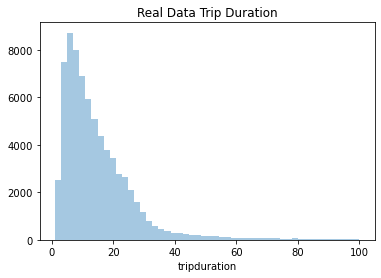

In [ ]:
sns.distplot((chicago.tripduration), kde=False)
plt.title('Real Data Trip Duration')

We will limit trip durations to be less than 60 by removing outliers.

In [ ]:
chicago1h = chicago[chicago.tripduration < 60]  
chicago1hduration = chicago1h['tripduration'].values

Text(0.5, 1.0, 'Real Data Trip Duration')

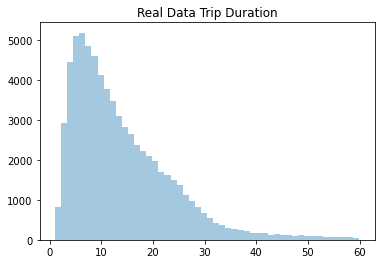

In [ ]:
sns.distplot(chicago1hduration, kde=False, label="Real Data")
plt.title('Real Data Trip Duration')

We will also arbitrarily initialize the model with weights .9, .1 and mean 100, 10 for the two Gaussian distributions, respectively.

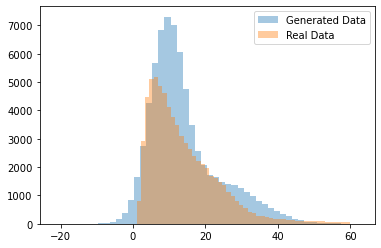

In [ ]:
data = chicago1hduration.reshape(-1,1)
 
#Fit Gaussian Mixture Model
gm = GaussianMixture(n_components=2,max_iter=100,weights_init=np.array([.9, .1]),means_init=np.array([[100],[10]]), n_init=20).fit(data)

#Parameter results
pi_0, pi_1 = gm.weights_[0], gm.weights_[1]
sigma_0, sigma_1 = gm.covariances_[0]**.5, gm.covariances_[1]**.5
mu_0, mu_1 = gm.means_[0], gm.means_[1]



# Create random_state so any random operation always returns the same result.
random_state = np.random.RandomState(1)

# Generate some data using the GMM parameters we just estimated above.
num_trips = chicago1hduration.shape[0]
# First let's create an array of bernouilli samples with probability of success pi_1.
dist_number = random_state.binomial(1, pi_1, size=num_trips)
# Now let's create two arrays of size n that hold data from the two Gaussian distributions
# we estimated.
dist_0_duration = random_state.randn(num_trips) * sigma_0 + mu_0
dist_1_duration = random_state.randn(num_trips) * sigma_1 + mu_1
# Now use the original array of bernouilli samples to subsample the two Gaussian arrays.
generated_duration = np.zeros(num_trips)
generated_duration[dist_number == 0] = dist_0_duration[0][dist_number == 0]
generated_duration[dist_number == 1] = dist_1_duration[0][dist_number == 1]

# Plot the generated data.
sns.distplot(generated_duration, kde=False, label="Generated Data")  
# Plot the real duration.
sns.distplot(chicago1hduration, kde=False, label="Real Data")  
# Add the legend to the plot.
plt.legend();

In [ ]:
print('mu_0:{}, mu_1:{}, sigma_0:{}, sigma_1:{}'.format(mu_0, mu_1, sigma_0[0], sigma_1[0]))

mu_0:[23.71261359], mu_1:[9.39342842], sigma_0:[10.46654073], sigma_1:[4.73428748]


### 3.3 Given the output of EM, which of the distributions captures the behavior of the subscribed customers?

The model with  mu_1 = 9.39 sigma_1 = 4.73 is the subscribers. We know this because subscribers take shorter trips in general than customers. Next, we will use the posteriors of the distribution of subscribed users to create classifiers to classify whether a customer is a subscriber or not.


### 3.4 Classifier to classify customers as subscribers
Here I design a classifier which classifies a customer as a Subscriber if their posterior prob > 0.5. The error of this classifier given the Subscriber User Types in the each of the three cities datasets are shown below:

In [ ]:
gaussian_prob_0 = (np.exp(-(chicago1hduration - mu_0) ** 2 / (2 *
sigma_0)) / (np.sqrt(2 * np.pi) * sigma_0))

gaussian_prob_1 = (np.exp(-(chicago1hduration - mu_1) ** 2 / (2 *
sigma_1)) / (np.sqrt(2 * np.pi) * sigma_1))

normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1

posteriors = pi_1 * gaussian_prob_1 / normalizing_factor
posteriors

array([[7.25075661e-01, 9.99999976e-01, 9.99999988e-01, ...,
        1.35911265e-02, 5.22897197e-11, 9.99950193e-01]])

In [ ]:
classified_subscribers = posteriors > 0.5
error = classified_subscribers[0] != chicago1h.usertype.map({'Customer':0,'Subscriber':1}).values
print('Chicago Classifier error:',np.sum(error)/len(error))

Chicago Classifier error: 0.2435639638619049


In [ ]:
gaussian_prob_0 = (np.exp(-(ny[ny.tripduration < 60].tripduration.values - mu_0) ** 2 / (2 *
sigma_0)) / (np.sqrt(2 * np.pi) * sigma_0))

gaussian_prob_1 = (np.exp(-(ny[ny.tripduration < 60].tripduration.values - mu_1) ** 2 / (2 *
sigma_1)) / (np.sqrt(2 * np.pi) * sigma_1))

normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1

posteriors = pi_1 * gaussian_prob_1 / normalizing_factor

subscribers_ny = posteriors > 0.5
error = subscribers_ny[0] != ny[ny.tripduration < 60].usertype.map({'Customer':0,'Subscriber':1}).values
print('NY Classifier error:',np.sum(error)/len(error))

NY Classifier error: 0.2584115934414746


In [ ]:
gaussian_prob_0 = (np.exp(-(dc[dc['Duration (min)'] < 60]['Duration (min)'].values - mu_0) ** 2 / (2 *
sigma_0)) / (np.sqrt(2 * np.pi) * sigma_0))

gaussian_prob_1 = (np.exp(-(dc[dc['Duration (min)'] < 60]['Duration (min)'].values - mu_1) ** 2 / (2 *
sigma_1)) / (np.sqrt(2 * np.pi) * sigma_1))

normalizing_factor = pi_0 * gaussian_prob_0 + pi_1 * gaussian_prob_1

posteriors = pi_1 * gaussian_prob_1 / normalizing_factor

subscribers_dc = posteriors > 0.5
error = subscribers_dc[0] != dc[dc['Duration (min)'] < 60]['Member Type'].map({'Casual':0,'Registered':1}).values 
print('DC Classifier error:',np.sum(error)/len(error))

DC Classifier error: 0.24324494750449285


**The classifier has the same performance on NY and DC datasets. The error rates stays around 24 to 25%, i.e. accuracies between 75-76%.**

## 4. Causality and Experimental Design

In [ ]:
day = pd.read_csv(r"/Users/kyjurou/Documents/Courses/bikeshare_proj/bikeshare/day.csv")
import statsmodels.api as sm

In [ ]:
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [7]:
day.weathersit.value_counts()

1    463
2    247
3     21
Name: weathersit, dtype: int64

`Weathersit`

1: Clear, Few clouds, Partly cloudy, Partly cloudy\
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist\
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds\

### 4.1.1 The causal model

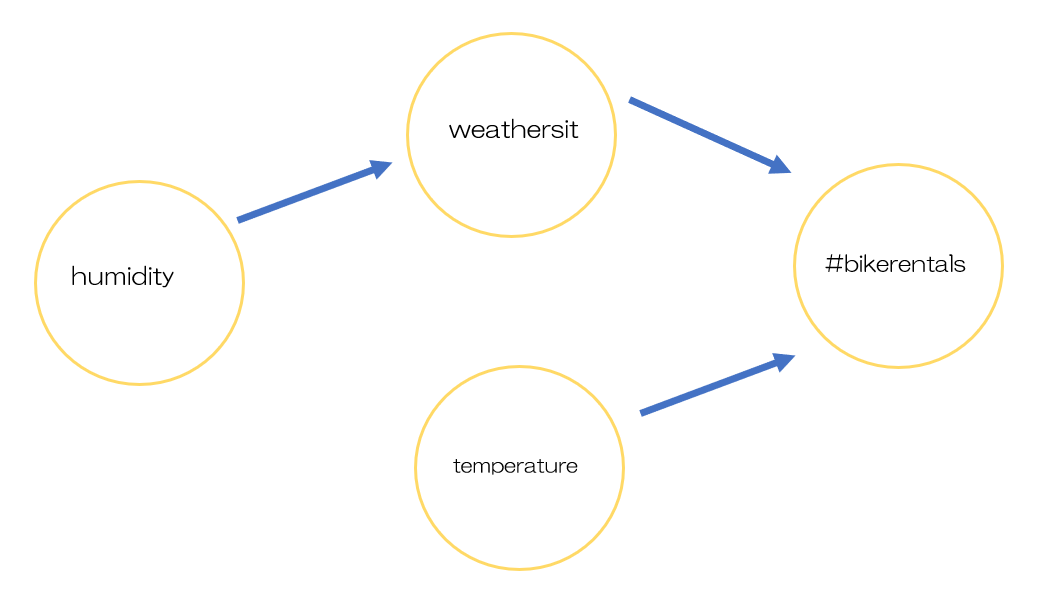

**Assumptions:**


We know X* is `weathersit`, X is `temperature`, Z is `humidity`, and Y is bike rentals `cnt`.
* Instrumental variable is independent of predictor variable.
    * The correlation between `humidity` and bike rentals `cnt` is 0.100 which is extremely weak.
* Instrumental variable is correlated with X*.
    * The correlation between `humidity` and `weathersit` is 0.59
* X*, or weathersit, is correlated with our predictor variable.
    * The correlation between `weathersit` and bike rentals `cnt` is 0.29.
* X, or temperature, is correlated with our predictor variable.
    * The correlation between `temperature` and bike rentals `cnt` is fairly strong, 0.63.
* Weather and temperature shouldn't be correlated.
    * The correlation between `weathersit` and `temperature` is 0.12

In [127]:
day[['weathersit', 'temp', 'hum','cnt']].corr()

,weathersit,temp,hum,cnt
weathersit,1.000000,-0.120602,0.591045,-0.297391
temp,-0.120602,1.000000,0.126963,0.627494
hum,0.591045,0.126963,1.000000,-0.100659
cnt,-0.297391,0.627494,-0.100659,1.000000


### 4.1.2 2 Stage Least Squares

**The 2SLS procedure works in the following way:**

**We wish to estimate the causal effect of weather on the number of bikes rented. We cannot assume that correlation between weather and bike rentals implies causation due to other confounding factors. However, we can attempt to estimate this effect through an instrumental variable, humidity. If humidity is sufficiently correlated with weather, the we can use this variable to evaluate the effect since we can assume humidity does not directly affect the number of bike rentals. In 2SLS, we essentially run OLS twice. In the first stage, we find weather through humidity and temperature. In the second stage, we use these weather predictions as well as temperature to predict the number of bike rentals. The coefficients of the weather variable in the second stage can be used to describe its causal effect on bike rentals.**

In [128]:
# First Stage
weathersit = day['weathersit'].values
stage1_features = day[['hum','temp']].values
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(weathersit, stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params # predicted coefficients

# Get predictions for weathersit
weather_predicted = stage1_ols_results[0] + stage1_ols_results[1] * day['hum'].values + stage1_ols_results[2] * day['temp'].values

# Get predictions for weathersit
weather_predicted = stage1_ols_results[0] + stage1_ols_results[1] * day['hum'].values + stage1_ols_results[2] * day['temp'].values

# Second Stage
num_rentals = day['cnt'].values 
stage2_features = np.concatenate([weather_predicted.reshape(len(weather_predicted),1), 
                                  day['temp'].values.reshape(len(weather_predicted),1)],axis=1) 
stage2_features_w_const = sm.add_constant(stage2_features)
stage2_model = sm.OLS(num_rentals, stage2_features_w_const) 
stage2ols_results = (stage2_model.fit()).params 
alpha_2SLS = stage2ols_results[1]
alpha_2SLS

-1057.298164468053

**We see that the coefficient is -1057, which means that there's a strong negative affect of weather on bike rentals. Specifically, for every increase of 1 in weather situation, we see a decrease of -1057 on bike rentals.**

In [129]:
weathersit = day['weathersit'].values
stage1_features = day[['hum','temp']].values
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(weathersit, stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params
predictions = stage1_ols_results[0] + stage1_ols_results[1] * day['hum'].values + stage1_ols_results[2] * day['temp'].values

casual_rentals = day['casual'].values
stage2_features = np.concatenate([predictions.reshape(len(predictions),1), day['temp'].values.reshape(len(predictions),1)],axis=1)
stage2_features_w_const = sm.add_constant(stage2_features)
stage2_model = sm.OLS(casual_rentals, stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params
alpha_2SLS = stage2ols_results[1]
alpha_2SLS


-303.37901939504644

In [130]:
weathersit = day['weathersit'].values
stage1_features = day[['hum','temp']].values
stage1_features_w_const = sm.add_constant(stage1_features)
stage1_ols = sm.OLS(weathersit, stage1_features_w_const)
stage1_ols_results = (stage1_ols.fit()).params 
predictions = stage1_ols_results[0] + stage1_ols_results[1] * day['hum'].values + stage1_ols_results[2] * day['temp'].values

registered_rentals = day['registered'].values
stage2_features = np.concatenate([predictions.reshape(len(predictions),1), day['temp'].values.reshape(len(predictions),1)],axis=1)
stage2_features_w_const = sm.add_constant(stage2_features) 
stage2_model = sm.OLS(registered_rentals, stage2_features_w_const)
stage2ols_results = (stage2_model.fit()).params
alpha_2SLS = stage2ols_results[1]
alpha_2SLS

-753.9191450730061

**For casual users, the coefficient is -303, meaning for every increase of 1 in weather situation, we lose 303 casual bike rentals. For subscribers, the coefficient is -754, meaning for every increase of 1 in weather situation, we lose 754 subscriber rentals.**

### 4.1.3 Summary & Future Exploration

In this part, I wanted to estimate the causal effect of weather situation on the number of bike rentals which can be useful for predicting the number of bike rentals on given day with this variable. 2SLS is used because there are confounding variables (remember, correlation does not equal causation). Using an instrumental variable provides pseudo-randomization. Using humidity as our instrumental variable in 2SLS, I found that weather situation negatively affects the number of bike rentals.


1. For casual (non-subscriber) users, the effect of adverse weather is much lower than for subscribers. One possible reason is that casual users may be less accustomed to riding in bad weather conditions so they don't really know how to manage riding in bad weather, or possibly because they don't rely on bikes so they can deal with not riding every once in a while. However, for subscribers, since bikes are probably a main mode of transportation; they are also likely to be fully aware of the inconvenience and consequences of riding in bad weather. In weather situations light rain, they are more likely to rely on the bikes for riding to and from work as compared to a casual (non-subscriber) rider.


2. 2SLS is used to control for confounding variables. Because the number of bike rentals can be influenced by several factors, only choosing one is likely to include the confounding variables. For instance, another potential confounding variable is socioeconomic background of riders; there are riders who save money riding a bike instead of driving a car.  A variable such as the use case of the bike  (leisure, business) can also affect the number of bike rentals.


For future analysis, I would like to use data on the location of bikes docks and how they are categorized (residential, leisure areas, areas with lots of offices, near transportion hubs like the metro, etc.) and the distance of trips between docks. This would further understanding of how people are using the bikes and whether the distance of their trip may cause them to use alternative transportation methods. I would try to use location types to determine the use cases of different routes people take and see how use cases correlates with `weathersit`. My guess is that use case could be correlated with `weathersit` because someone who just wants to enjoy the view will not go out to ride a bike when it's raining, versus someone who needs has somewhere to go and has no other alternative transportation. Instead of `humidity`, I would use use case as an instrumental variable to see the difference in modeling. It would also be interesting to examine them as regular explanatory variables (like `temperature`)